In [1]:
from IPython.display import clear_output
from typing import List, Optional

import datetime
import functools
import gpflow as gpf
import hydra
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import palettable
import tensorflow as tf
import tensor_annotations.tensorflow as ttf
import tensorflow_probability as tfp

from gpflow import default_float, default_jitter
from gpflow.conditionals import uncertain_conditional, base_conditional
from matplotlib import cm
from numpy import random
from omegaconf import DictConfig
from simenvs import make

from modeopt.cost_functions import ControlQuadraticCostFunction, TargetStateCostFunction, StateDiffCostFunction, quadratic_cost_fn
from modeopt.controllers.utils import initialise_deterministic_trajectory, build_mode_variational_objective
from modeopt.controllers import TrajectoryOptimisationController
from modeopt.constraints import build_mode_chance_constraints_scipy
from modeopt.custom_types import Dataset
from modeopt.dynamics.conditionals import svgp_covariance_conditional
from modeopt.plotting import ModeOptContourPlotter
from modeopt.rollouts import rollout_controls_in_dynamics, rollout_controller_in_dynamics, rollout_controller_in_env, collect_data_from_env, rollout_policy_controller_in_dynamics
from modeopt.trajectories import ControlTrajectoryDist
from modeopt.utils import model_from_DictConfig, combine_state_controls_to_input, append_zero_control
from modeopt.mode_opt import ModeOpt
from mogpe.keras.callbacks.tensorboard import PlotFn, TensorboardImageCallback
from mogpe.keras.mixture_of_experts import MixtureOfSVGPExperts
from mogpe.keras.plotting import MixtureOfSVGPExpertsContourPlotter
from mogpe.keras.utils import sample_mosvgpe_inducing_inputs_from_data, model_from_yaml

%matplotlib inline

tfd = tfp.distributions

CMAP = palettable.scientific.sequential.Bilbao_15.mpl_colormap

meaning_of_life = 42
tf.random.set_seed(meaning_of_life)
np.random.seed(meaning_of_life)

## Initialise environment

In [2]:
env_name = "velocity-controlled-point-mass/scenario-7"

In [3]:
env = make(env_name)
state_dim = env.observation_spec().shape[0]
control_dim = env.action_spec().shape[0]

No constant_error found in toml config so using default : 0.0


## ModeOpt config

In [4]:
start_state = np.array([[-1.0, -2.0]])
target_state = np.array([[1.7, 3.0]])
mode_satisfaction_prob = 0.8

## Sample initial data set from desired mode

In [5]:
# num_initial_states = 130
# num_initial_states = 30

(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)


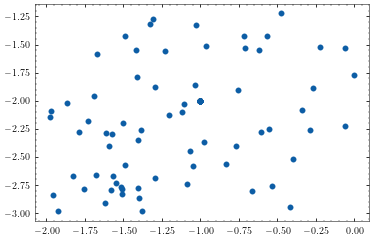

In [6]:
def sample_env_trajectories(horizon=15, num_trajectories=10):
    X, Y = [], []
    for i in range(num_trajectories):
        controls = np.random.uniform(
            env.action_spec().minimum,
            env.action_spec().maximum,
            (horizon, env.action_spec().shape[-1]),
        )
        X_, Y_ = collect_data_from_env(env, start_state=start_state, controls=controls)
        X.append(X_)
        Y.append(Y_)
    X = np.concatenate(X, 0)
    Y = np.concatenate(Y, 0)
    width = 1.0
    mask_1 = X[:, 0] > start_state[0, 0] - width
    mask_2 = X[:, 0] < start_state[0, 0] + width
    mask_3 = X[:, 1] > start_state[0, 1] - width
    mask_4 = X[:, 1] < start_state[0, 1] + width
    mask = mask_1 & mask_2 & mask_3 & mask_4
    X_trimmed = X[mask]
    Y_trimmed = Y[mask]
    print(X_trimmed.shape)
    print(Y_trimmed.shape)
    return (X_trimmed, Y_trimmed)

initial_dataset = sample_env_trajectories(horizon = 15, num_trajectories=50)
dataset = initial_dataset
plt.scatter(dataset[0][:, 0], dataset[0][:, 1])
plt.show()

## Train dynamics on initial data set or load from config

In [7]:
initial_num_epochs = 20000
# num_epochs = 300
num_epochs = 1500
# batch_size = 128
batch_size = initial_dataset[0].shape[0]
dynamics_logging_epoch_freq = 100

load_from_config = True
# load_from_config = False
yaml_cfg_filename = "./keras_configs/mode_opt_explore_scenario_7.yaml"
load_ckpt_dir = "./experiments/exploration-prob-0.8/2022-03-29-18-14/ckpts"
load_ckpt_dir = "./experiments/exploration-prob-0.8/2022-03-30-13-33/ckpts"
load_ckpt_dir = "./experiments/exploration-prob-0.8/2022-03-30-14-22/ckpts"

In [8]:
now_time = datetime.datetime.now().strftime('%Y-%m-%d-%H-%M') #  now
log_dir = os.path.join(f"./experiments/explorative-prob-{mode_satisfaction_prob}", now_time)

In [9]:
if load_from_config:
    mode_optimiser = ModeOpt.load(load_ckpt_dir)
    mode_optimiser.log_dir = log_dir
else:
    mode_optimiser = model_from_yaml(yaml_cfg_filename, custom_objects={"ModeOpt": ModeOpt})
    mode_optimiser.dataset = (tf.constant(initial_dataset[0], dtype=default_float()),
                              tf.constant(initial_dataset[1], dtype=default_float())
                             )
    sample_mosvgpe_inducing_inputs_from_data(initial_dataset[0], mode_optimiser.dynamics.mosvgpe)
    mode_optimiser.dynamics_fit_kwargs.update({"epochs": initial_num_epochs, "batch_size": batch_size, "validation_split": 0.2})
#     dynamics_plotting_callbacks = build_contour_plotter_callbacks(mode_optimiser.dynamics.mosvgpe, logging_epoch_freq=dynamics_logging_epoch_freq, log_dir=mode_optimiser.log_dir)
#     mode_optimiser.add_dynamics_callbacks(dynamics_plotting_callbacks)
#     gpf.utilities.set_trainable(mode_optimiser.dynamics.mosvgpe.gating_network.gp.inducing_variable, False)
    mode_optimiser.optimise_dynamics()
#     gpf.utilities.set_trainable(mode_optimiser.dynamics.mosvgpe.gating_network.gp.kernel, False)

2022-04-08 09:39:41.881013: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


setting desired mode to 1
╒════════════════════════════════════════════════════════════════╤═══════════╤════════════════╤═════════╤═════════════╤═════════════╤═════════╤══════════════════════════════════════════╕
│ name                                                           │ class     │ transform      │ prior   │ trainable   │ shape       │ dtype   │ value                                    │
╞════════════════════════════════════════════════════════════════╪═══════════╪════════════════╪═════════╪═════════════╪═════════════╪═════════╪══════════════════════════════════════════╡
│ IndependentPosteriorMultiOutput.kernel.kernels[0].variance     │ Parameter │ Softplus       │         │ True        │ ()          │ float64 │ 1.4978003107997662                       │
├────────────────────────────────────────────────────────────────┼───────────┼────────────────┼─────────┼─────────────┼─────────────┼─────────┼──────────────────────────────────────────┤
│ IndependentPosteriorMultiOutput.kerne

2022-04-08 09:39:42.210714: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-04-08 09:39:42.210725: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-04-08 09:39:42.211093: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


Update the data set.

In [10]:
mode_optimiser.start_state = tf.constant(start_state, dtype=default_float())

Set the correct desired dynamics mode.

In [11]:
def which_desired_mode(mode_optimiser, initial_dataset):
    probs = mode_optimiser.dynamics.mosvgpe.gating_network.predict_mixing_probs(initial_dataset[0])
    mean_probs = tf.reduce_mean(probs, 0)
    return int(tf.math.argmax(mean_probs))

desired_mode = which_desired_mode(mode_optimiser, initial_dataset)
print("Desired mode is {}".format(desired_mode))
mode_optimiser.desired_mode = desired_mode

Desired mode is 1


Save the learned dynamics model.

In [12]:
mode_optimiser.save()

## Configure the explorative controller

In [13]:
horizon = 15
max_iterations = 1000
keep_last_solution = True
method = "SLSQP"

In [14]:
terminal_state_cost_matrix = tf.eye(state_dim, dtype=default_float()) * 100
state_diff_cost_matrix = tf.eye(state_dim, dtype=default_float()) * 0.01
state_diff_cost_matrix = tf.eye(state_dim, dtype=default_float()) * 1.0
# control_cost_matrix = tf.eye(control_dim, dtype=default_float()) * 0.1
control_cost_matrix = tf.eye(control_dim, dtype=default_float()) * 0.5
# control_cost_matrix = tf.eye(control_dim, dtype=default_float()) * 1.0

# terminal_cost_fn = TargetStateCostFunction(weight_matrix=terminal_state_cost_matrix, target_state=start_state)
terminal_cost_fn = TargetStateCostFunction(weight_matrix=terminal_state_cost_matrix, target_state=target_state)
control_cost_fn = ControlQuadraticCostFunction(weight_matrix=control_cost_matrix)
state_diff_cost_fn = StateDiffCostFunction(weight_matrix=state_diff_cost_matrix, target_state=target_state)

cost_fn = control_cost_fn + state_diff_cost_fn
# cost_fn = state_diff_cost_fn
# cost_fn = control_cost_fn
# cost_fn = control_cost_fn + state_diff_cost_fn + terminal_cost_fn
# cost_fn = state_diff_cost_fn
# cost_fn = terminal_cost_fn + state_diff_cost_fn

In [15]:
def conditional_gating(state_means, control_means, state_vars, control_vars):
    h_means_prior, h_vars_prior = mode_optimiser.dynamics.uncertain_predict_gating(state_means, control_means)
    gating_gp = mode_optimiser.dynamics.desired_mode_gating_gp 

    input_means, input_vars = combine_state_controls_to_input(
        state_means, control_means, state_vars, control_vars
    )
    
    h_means, h_vars = h_means_prior[0:1, :], h_vars_prior[0:1, :]
    for t in range(1, horizon):
        Xnew = input_means[t:t+1, :]
        Xobs = tf.concat([input_means[:t, :], input_means[t+1:, :]], 0)
        f = tf.concat([h_means_prior[:t, :], h_means_prior[t+1:, :]], 0)

        Knn = svgp_covariance_conditional(X1=Xnew, X2=Xnew, svgp=gating_gp)[0, 0, :]
        Kmm = svgp_covariance_conditional(X1=Xobs, X2=Xobs, svgp=gating_gp)[0, :, :]
        Kmn = svgp_covariance_conditional(X1=Xobs, X2=Xnew, svgp=gating_gp)[0, :, :]
        Kmm += tf.eye(Kmm.shape[0], dtype=default_float()) * default_jitter()
        h_mean, h_var = base_conditional(
            Kmn=Kmn,
            Kmm=Kmm,
            Knn=Knn,
            f=f,
            full_cov=False,
            q_sqrt=None,
            white=False,
        )
        h_means = tf.concat([h_means, h_mean], 0)
        h_vars = tf.concat([h_vars, h_var], 0)
    return h_means, h_vars
    
def conditional_gating_temporal(state_means, control_means, state_vars, control_vars):
    h_means_prior, h_vars_prior = mode_optimiser.dynamics.uncertain_predict_gating(state_means, control_means)
    gating_gp = mode_optimiser.dynamics.desired_mode_gating_gp 

    input_means, input_vars = combine_state_controls_to_input(
        state_means, control_means, state_vars, control_vars
    )
    
    h_means, h_vars = h_means_prior[0:1, :], h_vars_prior[0:1, :]
    for t in range(1, horizon):
        Xnew = input_means[t:t+1, :]
        Xobs = input_means[0:t, :]
        f = h_means_prior[0:t, :]

        Knn = svgp_covariance_conditional(X1=Xnew, X2=Xnew, svgp=gating_gp)[0, 0, :]
        Kmm = svgp_covariance_conditional(X1=Xobs, X2=Xobs, svgp=gating_gp)[0, :, :]
        Kmn = svgp_covariance_conditional(X1=Xobs, X2=Xnew, svgp=gating_gp)[0, :, :]
        Kmm += tf.eye(Kmm.shape[0], dtype=default_float()) * default_jitter()
        h_mean, h_var = base_conditional(
            Kmn=Kmn,
            Kmm=Kmm,
            Knn=Knn,
            f=f,
            full_cov=False,
            q_sqrt=None,
            white=False,
        )
        h_means = tf.concat([h_means, h_mean], 0)
        h_vars = tf.concat([h_vars, h_var], 0)
    return h_means, h_vars

In [16]:
# def explorative_objective(initial_solution: ControlTrajectoryDist) -> ttf.Tensor0:
#     control_means = initial_solution(variance=False)
#     control_vars = None
#     state_means, state_vars = rollout_controls_in_dynamics(
#         dynamics=mode_optimiser.dynamics,
#         start_state=start_state,
#         control_means=control_means,
#         control_vars=control_vars,
#     )

# #     h_means_prior, h_vars_prior = mode_optimiser.dynamics.uncertain_predict_gating(state_means[:-1, :], control_means)
# #     gating_gp = mode_optimiser.dynamics.desired_mode_gating_gp 

# #     input_means, input_vars = combine_state_controls_to_input(
# #         state_means[:-1, :], control_means, state_vars[:-1, :], control_vars
# #     )
    
#     h_means, h_vars = conditional_gating_temporal(state_means[1:, :], control_means, state_vars[1:, :], control_vars)
# #     h_means, h_vars = h_means_prior[0:1, :], h_vars_prior[0:1, :]
# #     for t in range(1, horizon):
# #         Xnew = input_means[t:t+1, :]
# #         Xobs = input_means[0:t, :]
# #         f = h_means_prior[0:t, :]

# #         Knn = svgp_covariance_conditional(X1=Xnew, X2=Xnew, svgp=gating_gp)[0, 0, :]
# #         Kmm = svgp_covariance_conditional(X1=Xobs, X2=Xobs, svgp=gating_gp)[0, :, :]
# #         Kmn = svgp_covariance_conditional(X1=Xobs, X2=Xnew, svgp=gating_gp)[0, :, :]
# #         Kmm += tf.eye(Kmm.shape[0], dtype=default_float()) * default_jitter()
# #         h_mean, h_var = base_conditional(
# #             Kmn=Kmn,
# #             Kmm=Kmm,
# #             Knn=Knn,
# #             f=f,
# #             full_cov=False,
# #             q_sqrt=None,
# #             white=False,
# #         )
# #         h_means = tf.concat([h_means, h_mean], 0)
# #         h_vars = tf.concat([h_vars, h_var], 0)
#     h_dist = tfd.MultivariateNormalDiag(h_means, h_vars)
#     gating_entropy = h_dist.entropy()
#     return -tf.reduce_sum(gating_entropy) + cost_fn(state_means, control_means, state_vars, control_vars)

In [17]:
from modeopt.controllers import FeedbackController

def explorative_policy_objective(policy_controller):
    state_means, state_vars, controls = rollout_policy_controller_in_dynamics(
        dynamics=mode_optimiser.dynamics,
        controller=policy_controller,
        horizon=horizon,
        start_state=start_state,
    )
#     print('state_means')
#     print(state_means)
#     print(state_vars)
#     print(controls)

    h_means, h_vars = conditional_gating_temporal(state_means[1:, :], controls, state_vars[1:, :], control_vars=None)
    h_dist = tfd.MultivariateNormalDiag(h_means, h_vars)
    gating_entropy = h_dist.entropy()
    return -tf.reduce_sum(gating_entropy) + cost_fn(state_means, controls, state_vars, control_var=None)

class Policy(FeedbackController):
    def __init__(self, state_dim: int, control_dim: int, horizon: int, hidden_sizes: List[int], activation=tf.tanh, output_activation=None):
        super().__init__()
        self.state_dim = state_dim
        self.control_dim = control_dim
        self.horizon = horizon
        self.hidden_sizes = hidden_sizes
        self.activation = activation
        self.output_activation = output_activation
    
    def __call__(self, state, timestep: Optional[int] = None):
        if len(state.shape) == 1:
            state = tf.reshape(state, [1, -1])
#         print('here')
#         print(state)
#         x = state[0, :]
        x = state
        # Build a feedforward neural network
        for size in self.hidden_sizes:
            x = tf.keras.layers.Dense(units=size, activation=self.activation)(x)
#             print('x')
#             print(x)
        control = tf.keras.layers.Dense(units=self.control_dim, activation=self.output_activation)(x)
#         control = tf.reshape(control, [1, -1])
#         print("control")
#         print(control)
        return control
        
    def optimise(self):
        # Update the policy and implement early stopping using KL divergence
        for _ in range(train_policy_iterations):
#             loss = explorative_policy_objective(self)
#             tf.print("Loss: {}".format(loss))
            with tf.GradientTape() as tape:  # Record operations for automatic differentiation.
                policy_loss = explorative_policy_objective(self)
                tf.print("Loss: {}".format(policy_loss))

            policy_grads = tape.gradient(policy_loss, self.trainable_variables)
            policy_optimizer.apply_gradients(zip(policy_grads, self.trainable_variables))
        return policy_loss
        
    @tf.function
    def train_policy(observation_buffer, action_buffer):

        with tf.GradientTape() as tape:  # Record operations for automatic differentiation.
            policy_loss = explorative_policy_objective(self)

        policy_grads = tape.gradient(policy_loss, self.trainable_variables)
        policy_optimizer.apply_gradients(zip(policy_grads, self.trainable_variables))

        kl = tf.reduce_mean(
            logprobability_buffer
            - logprobabilities(actor(observation_buffer), action_buffer)
        )
        kl = tf.reduce_sum(kl)
        return kl

    def control_dim(self):
        return self.control_dim
    
    def horizon(self):
        return self.horizon
    
train_policy_iterations = 200
hidden_sizes = [64, 64]
policy_learning_rate = 3e-4
policy_optimizer = tf.keras.optimizers.Adam(learning_rate=policy_learning_rate)
policy_controller = Policy(state_dim=state_dim, control_dim=control_dim, horizon=horizon, hidden_sizes=hidden_sizes)
# print(policy_controller(start_state.reshape(1, -1)))

In [ ]:
policy_controller.optimise()

In [18]:
# mode_chance_constraints = build_mode_chance_constraints_scipy(mode_optimiser.dynamics, 
#                                                               start_state, 
#                                                               horizon, 
#                                                               control_dim=control_dim,
#                                                               lower_bound=mode_satisfaction_prob)
# explorative_controller = TrajectoryOptimisationController(
#     max_iterations=max_iterations,
#     initial_solution=initial_solution_in_mode,
#     objective_fn=explorative_objective,
#     keep_last_solution=keep_last_solution,
#     constraints=[mode_chance_constraints],
#     method=method,
# )
# mode_optimiser.explorative_controller = explorative_controller

In [19]:
mode_optimiser.explorative_controller = policy_controller

## Configure plotter

In [20]:
def create_test_inputs(x_min=[-3, -3], x_max=[3, 3], input_dim=4, num_test: int = 1600, factor: float = 1.2):
    sqrtN = int(np.sqrt(num_test))
    xx = np.linspace(x_min[0] * factor, x_max[0] * factor, sqrtN)
    yy = np.linspace(x_min[1] * factor, x_max[1] * factor, sqrtN)
    xx, yy = np.meshgrid(xx, yy)
    test_inputs = np.column_stack([xx.reshape(-1), yy.reshape(-1)])
    if input_dim > 2:
        zeros = np.zeros((num_test, input_dim - 2))
        test_inputs = np.concatenate([test_inputs, zeros], -1)
    return test_inputs, xx, yy

test_inputs, xx, yy = create_test_inputs()
plotter = ModeOptContourPlotter(mode_optimiser, test_inputs=test_inputs, static=False, explorative=True)

NotImplementedError: 

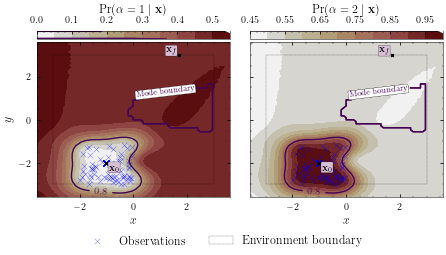

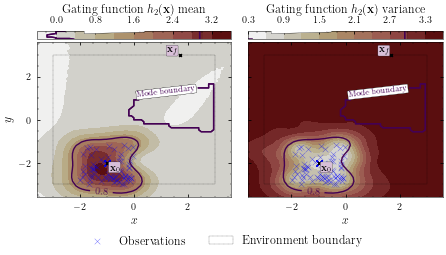

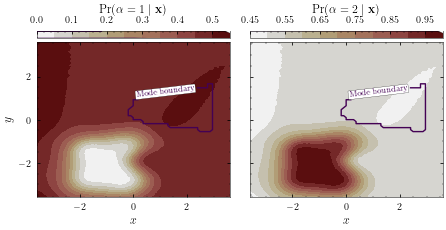

In [21]:
image_save_dir = os.path.join(mode_optimiser.log_dir, "images")
try:
    os.makedirs(image_save_dir)
except FileExistsError:
    pass

def plot_data_over_gating_network_and_save(step: int, epoch: int, save: bool = True):
    plotter.plot_data_over_mixing_probs()
    if save:
        save_filename = os.path.join(image_save_dir, "data_over_mixing_probs_step_{}_epoch_{}.pdf".format(step, epoch))
        plt.savefig(save_filename, transparent=True)
    
    plotter.plot_data_over_desired_gating_network_gp()
    if save:
        save_filename = os.path.join(image_save_dir, "data_over_desired_gating_gp_step_{}_epoch_{}.pdf".format(step, epoch))
        plt.savefig(save_filename, transparent=True)

def plot_trajectories_over_gating_network_and_save(step: int, save: bool = True):
    plotter.plot_trajectories_over_mixing_probs()
    if save:
        save_filename = os.path.join(image_save_dir, "trajectories_over_mixing_probs_step_{}.pdf".format(step))
        plt.savefig(save_filename, transparent=True)
    
    plotter.plot_trajectories_over_desired_gating_network_gp()
    if save:
        save_filename = os.path.join(image_save_dir, "trajectories_over_desired_gating_gp_step_{}.pdf".format(step))
        plt.savefig(save_filename, transparent=True)

plot_data_over_gating_network_and_save(step=0, epoch=0)
plot_trajectories_over_gating_network_and_save(step=0)

## Configure ModeOpt and callbacks

In [ ]:
# mode_optimiser.dataset = (mode_optimiser.dataset[0][:130, :], mode_optimiser.dataset[1][:130, :])

In [ ]:
# logging_epoch_freq = 60
num_epochs = 10000
logging_epoch_freq = math.floor((num_epochs)/5)
save_epoch_freq = math.floor((num_epochs)/5)
num_steps = 35
dataset = initial_dataset
# batch_size = 128
batch_size = mode_optimiser.dataset[0].shape[0]

mode_optimiser.dynamics_fit_kwargs.update({"epochs": num_epochs, "batch_size": batch_size, "validation_split": 0.2})
mode_optimiser.dynamics_fit_kwargs

Callbacks for dynamics learning.

In [ ]:
class PlottingCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if epoch % logging_epoch_freq == 0:
            plot_data_over_gating_network_and_save(step=step, epoch=epoch)

class CustomSaver(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if epoch % save_epoch_freq == 0:  # or save after some epoch, each k-th epoch etc.
            self.model.save(os.path.join(mode_optimiser.ckpt_dir, "step_{}_epoch_{}".format(step, epoch)), save_format="tf")
            
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor="loss",
    min_delta=0,
    patience=500,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
)
callbacks = [PlottingCallback(),
             CustomSaver(),
             early_stopping_cb,
#              tf.keras.callbacks.ModelCheckpoint(
#                  filepath=os.path.join(save_dir + "ckpts/ModeOptDynamics"),
#                  monitor="loss",
#                  save_format="tf",
#                  save_best_only=False,
#                  save_freq=500),
             tf.keras.callbacks.TensorBoard(log_dir=log_dir)
            ]

In [ ]:
mode_optimiser.dynamics(dataset[0]) # call ModeOptDynamics to build it for saving
mode_optimiser.dynamics_callbacks = []
mode_optimiser.add_dynamics_callbacks(callbacks)

In [ ]:
# gpf.utilities.set_trainable(mode_optimiser.dynamics.mosvgpe.gating_network.gp.kernel, False)
# gpf.utilities.set_trainable(mode_optimiser.dynamics.mosvgpe.experts_list[desired_mode].gp.kernel, False)

In [ ]:
for step in range(1, num_steps):
    new_dataset = mode_optimiser.explore_env()
    mode_optimiser.update_dataset(new_dataset)
    mode_optimiser.dynamics_fit_kwargs.update({"batch_size": mode_optimiser.dataset[0].shape[0]})
    print("Data set size: {}".format(mode_optimiser.dataset[0].shape))
    plot_data_over_gating_network_and_save(step=step, epoch=0, save=False)
    plot_trajectories_over_gating_network_and_save(step=step, save=True)
    plt.show()
    mode_optimiser.optimise_dynamics()

In [ ]:
for step in range(num_steps, num_steps*2):
    new_dataset = mode_optimiser.explore_env()
    mode_optimiser.update_dataset(new_dataset)
    mode_optimiser.dynamics_fit_kwargs.update({"batch_size": mode_optimiser.dataset[0].shape[0]})
    print("Data set size: {}".format(mode_optimiser.dataset[0].shape))
    plot_data_over_gating_network_and_save(step=step, epoch=0, save=False)
    plot_trajectories_over_gating_network_and_save(step=step, save=True)
    plt.show()
    mode_optimiser.optimise_dynamics()

In [ ]:
# for step in range(num_steps, num_steps*2):
#     new_dataset = mode_optimiser.explore_env()
#     mode_optimiser.update_dataset(new_dataset)
#     batch_size = mode_optimiser.dataset[0].shape[0]
#     mode_optimiser.dynamics_fit_kwargs.update({"epochs": num_epochs, "batch_size": batch_size, "validation_split": 0.2})
#     print("Data set size: {}".format(mode_optimiser.dataset[0].shape))
#     plot_data_over_gating_network_and_save(step=step, epoch=0, save=False)
#     plot_trajectories_over_gating_network_and_save(step=step, save=True)
#     plt.show()
#     mode_optimiser.optimise_dynamics()

In [ ]:
state_diff_cost_matrix